## 1. Generating Descriptive Sentences for Numbers (1–50)

This section defines a function to identify prime numbers and uses it to generate natural language descriptions for the numbers 1 through 50. 
Each number is labeled as either prime or composite, and as even or odd. The generated sentences are saved to a text file for further use in downstream tasks.

In [17]:
import sys
sys.path.append('../src')  # Add the src folder to the path

from utils import generate_number_sentences, save_sentences_to_file

# Generate and save sentences
sentences = generate_number_sentences()
save_sentences_to_file(sentences, "../data/numbers.txt")

## 2. Tokenizing Sentences and Building Vocabulary

This section processes the generated number descriptions by converting them into lowercase tokens and removing punctuation. 
The result is a list of tokenized sentences, each represented as a list of words. Additionally, a unique vocabulary set is built to track all distinct words across the dataset.
This step prepares the data for tasks such as word embedding training or further text analysis.

In [18]:
import re

with open("../data/numbers.txt", "r") as f:
    sentences = [line.strip() for line in f.readlines()]

# Function to tokenize a sentence:
# - Converts to lowercase
# - Removes punctuation
# - Splits into individual words
def tokenize(sentence: str) -> list[str]:
    sentence = sentence.lower()  # convert all text to lowercase
    sentence = re.sub(r"[^\w\s]", "", sentence)  # remove punctuation using regex
    return sentence.split()  # split by whitespace

# Apply the tokenizer to each sentence
tokenized_sentences = [tokenize(sentence) for sentence in sentences]

# Build a set of all unique words (vocabulary)
all_words = set()
for sentence in tokenized_sentences:
    for word in sentence:
        all_words.add(word)

# Display a sample of the tokenized sentences
print("A few tokenized sentences: ", tokenized_sentences[:10])

A few tokenized sentences:  [['1', 'is', 'a', 'composite', 'number'], ['1', 'is', 'an', 'odd', 'number'], ['2', 'is', 'a', 'prime', 'number'], ['2', 'is', 'an', 'even', 'number'], ['3', 'is', 'a', 'prime', 'number'], ['3', 'is', 'an', 'odd', 'number'], ['4', 'is', 'a', 'composite', 'number'], ['4', 'is', 'an', 'even', 'number'], ['5', 'is', 'a', 'prime', 'number'], ['5', 'is', 'an', 'odd', 'number']]


## 3. Training a Byte-Pair Encoding (BPE) Tokenizer with SentencePiece

This section uses the SentencePiece library to train a subword tokenizer on the number description sentences. 
The training data is first written to a temporary file, and then a Byte-Pair Encoding (BPE) model is trained with a vocabulary size of 36.
The resulting tokenizer model is then loaded and used to tokenize a sample sentence. This approach allows flexible tokenization 
that can handle rare or out-of-vocabulary words by breaking them into subword units.

In [19]:
import sentencepiece as spm

# create a temporary file to save adta for training the tokenizers
with open("tokenizer_data.txt", "w", encoding = "utf-8") as f:
    for sentence in sentences:
        f.write(sentence + "\n")

# train a Byte Pair Encoding (BPE) tokenizer
spm.SentencePieceTrainer.Train(input="tokenizer_data.txt", model_prefix="bpe_tokenizer", vocab_size=36)

# load trained tokenizer
sp = spm.SentencePieceProcessor(model_file = "bpe_tokenizer.model")

# Example tokenization
test_sentence = "7 is an odd number."
print("The tokenized output is: ", sp.encode(test_sentence, out_type = str))

The tokenized output is:  ['▁', '7', '▁', 'i', 's', '▁a', 'n', '▁', 'o', 'd', 'd', '▁', 'n', 'u', 'm', 'b', 'e', 'r', '.']


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: tokenizer_data.txt
  input_format: 
  model_prefix: bpe_tokenizer
  model_type: UNIGRAM
  vocab_size: 36
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 

## 4. Training a Word2Vec Model and Exploring Number Semantics

This section trains a Word2Vec embedding model using the tokenized number description sentences. 
The model learns vector representations for words based on their context within a window size of 5. 
After training for 5000 epochs, the model is saved and reloaded for evaluation. 
To explore semantic relationships learned by the model, word similarity scores are computed between selected pairs of numbers, 
highlighting how the model captures numerical and categorical properties like "even", "prime", and "composite".

In [20]:
from gensim.models import Word2Vec

# Train a Word2Vec model on the tokenized sentences
# - vector_size: dimension of word embeddings
# - window: context window size
# - min_count: ignore words with lower frequency
# - workers: number of threads to use
# - epochs: number of training iterations
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=35, window=5, min_count=1, workers=4, epochs=5000)

# Save and reload the trained model
word2vec_model.save('word2vec.model')
word2vec_model = Word2Vec.load('word2vec.model')

# Evaluate similarity between selected word pairs
print("\nWord Similarity (Two composite evens):")
print("4-6: ", word2vec_model.wv.similarity("4", "6"))

print("\nWord Similarity (A composite and a prime even):")
print("2-4: ", word2vec_model.wv.similarity("2", "4"))

print("\nWord Similarity (A composite even and a prime odd):")
print("4-7: ", word2vec_model.wv.similarity("4", "7"))


Word Similarity (Two composite evens):
4-6:  0.99618584

Word Similarity (A composite and a prime even):
2-4:  0.6828419

Word Similarity (A composite even and a prime odd):
4-7:  0.47457486


## 5. Visualizing Word Embeddings with PCA

This section visualizes the Word2Vec embeddings learned in the previous step by projecting the high-dimensional vectors into a 2D space using Principal Component Analysis (PCA).
Each word (or number) is plotted on a 2D scatter plot, labeled with its corresponding token. 
This visualization helps illustrate how the model has grouped semantically or structurally similar words (e.g., prime numbers, even numbers) based on their contextual similarity in the training corpus.

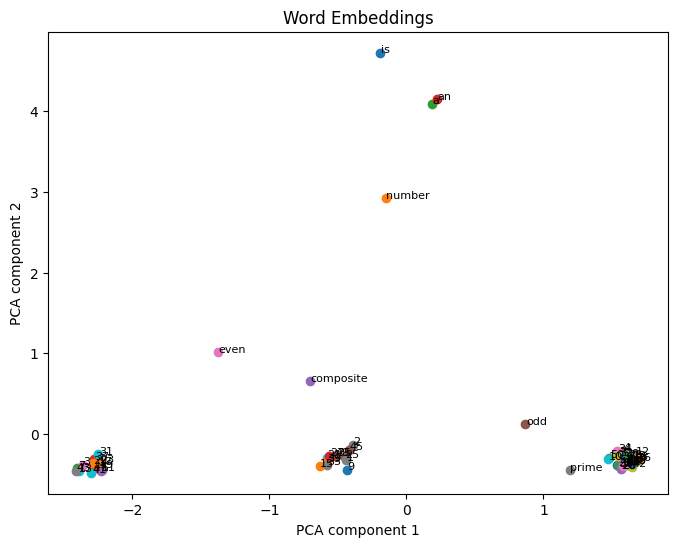

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get the word embeddings from word2vec
words = list(word2vec_model.wv.index_to_key)
vectors = [word2vec_model.wv[word] for word in words]

# Reduce to 2D using PCA
pca = PCA(n_components = 2)
reduced_vectors = pca.fit_transform(vectors)

# plot embeddings
plt.figure(figsize = (8,6))
for i, word in enumerate(words):
    plt.scatter(reduced_vectors[i,0], reduced_vectors[i,1], marker = 'o')
    plt.text(reduced_vectors[i,0] + 0.004, reduced_vectors[i, 1], word, fontsize = 8)

plt.title("Word Embeddings")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.show()

## 6. Tracking Word Embedding Evolution Over Training Epochs
This section investigates how word embeddings evolve as the Word2Vec model is trained with an increasing number of epochs.
Using a logarithmic scale of training epochs, a new Word2Vec model is trained at each step, and its word vectors are projected into 2D space using PCA.
The resulting 2D coordinates are saved into CSV files for each epoch, enabling later visualization or animation of how semantic structures (e.g., clusters of primes or evens) emerge and stabilize during training.
This temporal analysis provides insights into the convergence behavior of the embedding model.

In [16]:
import os
import pandas as pd
import numpy as np

epoch_list = np.unique(np.round(np.logspace(np.log10(1), np.log10(5000), num=100)).astype(int))

for n_epochs in epoch_list:
    word2vec_model=Word2Vec(
        sentences=tokenized_sentences,
        vector_size=35,
        window=10,
        min_count=1,
        sg=1,
        negative=10,
        epochs=n_epochs,
        workers=4,
        seed=412
    )

    words = list(word2vec_model.wv.index_to_key)
    vectors = [word2vec_model.wv[word] for word in words]

    pca = PCA(n_components = 2)
    reduced_vectors = pca.fit_transform(vectors)

    # create dataframe for reduced vectors
    df = pd.DataFrame(reduced_vectors, columns = ['x', 'y'])
    df['word'] = words 

    os.makedirs('pca_vectors', exist_ok = True)
    df.to_csv(f'../outputs/pca_vectors/word_embeddings_{n_epochs}.csv', index = False)

🔍 **Further Visualization**

For a detailed visualization of how the word embeddings evolve across training epochs, including semantic clustering of numbers (e.g., odd vs. even, prime vs. composite), please refer to the companion R Markdown notebook:

visualize_embeddings.Rmd

It includes PCA-based projections, dynamic grouping, and color-coded plots that illustrate the structure learned by the Word2Vec model over time.